In [1]:
import torch
import torchvision.transforms as transforms
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import sys
sys.path.append("../pyfiles/")
from util import *

# dataset

In [20]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
transform = {}
transform["train"] = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])
    
transform["test"] = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

In [21]:
def cuda2numpy(x):
    return x.detach().to("cpu").numpy()

In [22]:
class Dataset_Fashion_MNIST(torch.utils.data.Dataset):
    def __init__(self, root, classes, mode="train", transform=None, balance=[0.8,0.1,0.1]):
        
        self.transform = transform
        self.images = []
        self.labels = []

        images = {} 
        labels = {}
        
        for cl in classes:
            path_list = glob.glob(root + f"{cl}/*")
            path_list.sort()
            train_num = int(balance[0]*len(path_list))
            val_num = int(balance[1]*len(path_list))
            test_num = int(balance[2]*len(path_list))
            if mode=="train":
                path_list = path_list[:train_num]
            elif mode=="val":
                path_list = path_list[train_num:train_num+val_num]
            elif mode=="test":
                path_list = path_list[-test_num:]
            images[str(cl)] = path_list
            labels[str(cl)] = [cl]*len(path_list)
            
        # combine them together
        for label in classes:
            for image, label in zip(images[str(label)], labels[str(label)]):
                self.images.append(image)
                self.labels.append(label)

    def __getitem__(self, index):
        
        image = self.images[index]
        label = self.labels[index]
        
        with open(image, 'rb') as f:
            image = Image.open(f)
            image = image.convert("L")
        
        if self.transform is not None:
            image = self.transform(image)
            
        image = min_max(image, mean0=True)
#         image = torch.Tensor(np.reshape(min_max(image, mean0=False), (1, image.shape[0], -1)))
            
        return image, label
    
    def __len__(self):
        return len(self.images)

In [23]:
root = "../fashion_dataset1/"
classes = range(10)

In [24]:
dataset = Dataset_Fashion_MNIST(root, classes, "train", transform["train"])
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=64, shuffle=True)

In [25]:
x, label = dataset[0]

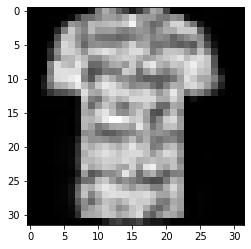

In [26]:
plt.imshow(image_from_numpy(cuda2numpy(x[np.newaxis]))[0])

# preparation

## Model Structure

- the model consists of 3 convolutional blocks and 3 fully connected layers.
- each convolutional block has a convolutional layer and a max pooling layer.
- ReLU is employed as an activation function except for the final layer.
- Ofcource, this is classification task, so you should use Softmax function in the last computation.

In [56]:
import torch.nn as nn
import torch.optim as optim

In [49]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.reshape(x.size(0), -1)

In [50]:
class ConvolutionalBlock(nn.Module):
    
    def __init__(self, nch_in, nch_out, kernel, activation="ReLU"):
        super(ConvolutionalBlock, self).__init__()
        layers = [
            nn.Conv2d(nch_in, nch_out, kernel_size=kernel, stride=1, padding=int((kernel-1)/2)),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ]
        if activation=="ReLU":
            layers.append(nn.ReLU())
        elif activation=="Tanh":
            layers.append(nn.Tanh())
        elif activation=="Sigmoid":
            layers.append(nn.Sigmoid())
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

In [51]:
class Classifier(nn.Module):
    
    def __init__(self, in_nch, out_nch, nch, kernel=3, activation="ReLU"):
        super(Classifier, self).__init__()
        
        self.conv_layers = nn.Sequential(
            ConvolutionalBlock(in_nch, nch, kernel, activation),
            ConvolutionalBlock(nch, nch*2, kernel, activation),
            ConvolutionalBlock(nch*2, nch*4, kernel, activation),
        )
        self.fcs = nn.Sequential(
            Flatten(),
            nn.Linear(4*4*(nch*4), out_nch),
            nn.Softmax()
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fcs(x)
        return x

## Algorithm

In [61]:
def do_test(net, testloader, device="cuda", mode="eval"):
    if mode=="train":
        net.train()
    elif mode=="eval":
        net.eval()
    else:
        return None
    labels = np.array([])
    with torch.no_grad():
        for itr, data in enumerate(testloader):
            images = data[0].to(device)
            label = cuda2numpy(data[1])
            output = cuda2numpy(net(images))
            if itr==0:
                outputs = output
            else:
                np.concatenate([outputs, output], axis=0)
                labels = np.append(labels, label)
    return labels, outputs

In [65]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('linear') != -1:        
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('batchnorm') != -1:     
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)

In [68]:
epoch_num = 301
lr = 0.001
save_parameter = False
test_interval = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [69]:
in_nch = 1
out_nch = len(classes)
nch = 16

In [70]:
net = Classifier(in_nch, out_nch, nch)
net = net.to(device)
net.apply(weights_init)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=lr)

In [71]:
# ----- adjustable parameters ----- #
train_batch = 64
val_batch = 64
# --------------------------------- #

dataset = Dataset_Fashion_MNIST(root, classes, "train", transform["train"])
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=train_batch, shuffle=True)
valset = Dataset_Fashion_MNIST(root, classes, "val", transform["train"])
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=val_batch, shuffle=True)
len(dataset), len(valset)

(48000, 6000)

In [74]:
net.train()
losses = []
losses_epoch = []
accs = []
acc_epoch = []
acc_test_list = []
best_epoch = 0
best_acc = 0
for epoch in range(epoch_num):
    for itr, data in enumerate(dataloader):
        net.train()
        x = data[0].to(device)
        label = data[1].to(device)
        opt.zero_grad()
        y = net(x)
        loss = criterion(y, label)
        loss.backward()
        opt.step()
        loss = cuda2numpy(loss)
        label = cuda2numpy(label)
        y = cuda2numpy(y)
        acc = (np.argmax(y, axis=1) == label).sum().item()/len(label)
        losses.append(loss)
        accs.append(acc)
    losses_epoch.append(np.mean(np.array(losses)))
    acc_epoch.append(np.mean(np.array(accs)))
    scheduler.step()
    if epoch%test_interval==0:
        labels, outputs = do_test_waveform(net, valloader, device, "eval")
        pred_labels = np.argmax(outputs, axis=1) 
        acc_test = accuracy_score(labels, pred_labels)
        acc_test_list.append(acc_test)
        if best_acc < acc_test:
            best_acc = acc_test
            best_epoch = epoch
            
    clear_output(wait=True)
    print(epoch)
    print(f"test acc in {epoch//test_interval*test_interval} : {acc_test}")
    print(f"best acc is   : {best_acc} in epoch{best_epoch}")
    
    if save_parameter:
        if epoch%test_interval==0:
            torch.save(net.state_dict(), 
                       f"../instant_model_parameter/emorec_fs{fs}_{bi_or_uni}wavenet_precausal_nchin{nch_in}_prefilter{prefilter}_res_in{resnch_in}_hidden{resnch_hidden}_out{resnch_out}_nchhidden{nch_hidden}_nchout{nch_out}_wavenetln{layer_num}_fsize{filter_list[0]}_reduce{reduce}_cnnnum{num_cls}_input{target_length}_epoch{epoch}.pth")
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(losses_epoch)
    ax.set_title("loss")
    ax = fig.add_subplot(1,2,2)
    ax.plot(acc_epoch, label="train")
    ax.plot(np.arange(epoch//test_interval+1)*test_interval, acc_test_list, label="val")
    ax.legend()
    ax.set_title('accuracy')
    plt.show()

KeyboardInterrupt: 

# training

- assignment
    - implementation of ResNet